<a href="https://colab.research.google.com/github/svperbeast/ai_lab/blob/main/ai_lab_20201104_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from torchvision import datasets, transforms, utils
from torch.utils import data

In [4]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

In [5]:
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
])

In [7]:
trainset = datasets.MNIST(root='./data',
                          train=True,
                          download=True,
                          transform=transform
                          )

testset = datasets.MNIST(root='./data',
                          train=False,
                          download=True,
                          transform=transform
                          )

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [32]:
BATCH_SIZE = 64

train_loader = data.DataLoader(dataset=trainset,
                               batch_size=BATCH_SIZE,
                               shuffle=True
                               )

test_loader = data.DataLoader(dataset=testset,
                               batch_size=BATCH_SIZE,
                               shuffle=True
                               )

In [33]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [34]:
images[0].shape

torch.Size([1, 28, 28])

In [35]:
print(labels)

tensor([9, 9, 3, 2, 1, 7, 3, 1, 5, 3, 3, 4, 6, 3, 9, 9, 4, 6, 6, 7, 6, 6, 0, 6,
        4, 8, 3, 1, 7, 3, 4, 5, 4, 2, 7, 7, 3, 6, 8, 0, 3, 1, 5, 2, 3, 8, 3, 4,
        4, 3, 4, 3, 1, 2, 5, 6, 6, 0, 8, 7, 8, 0, 2, 1])


In [36]:
CLASSES = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine'
}


for label in labels:
    index = label.item()
    print(CLASSES[index])

nine
nine
three
two
one
seven
three
one
five
three
three
four
six
three
nine
nine
four
six
six
seven
six
six
zero
six
four
eight
three
one
seven
three
four
five
four
two
seven
seven
three
six
eight
zero
three
one
five
two
three
eight
three
four
four
three
four
three
one
two
five
six
six
zero
eight
seven
eight
zero
two
one


(28, 28)


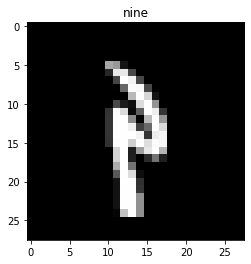

In [37]:
import matplotlib.pyplot as plt

idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

In [38]:
class Net(nn.Module):
  def __init__(self, dropout_p=0.2):
    super(Net, self).__init__()
    self.dropout_p = dropout_p

    self.fc1 = nn.Linear(28*28, 256) # 28*28: image size
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 10)

  def forward(self, x):
    x = x.view(-1, 28*28) # flatten

    x = torch.sigmoid(self.fc1(x))
    x = F.dropout(x, p=self.dropout_p, training=self.training)

    x = torch.sigmoid(self.fc2(x))
    x = F.dropout(x, p=self.dropout_p, training=self.training)

    x = self.fc3(x)
    return x

In [49]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.dropout = nn.Dropout2d(p=0.2)

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) # Conv: #channels
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
    """
    28*28 img ->
    conv 5*5 -> 24*24 -> maxpool2d 2*2 -> 12*12 ->
    conv 5*5 -> 8*8 -> maxpool2d 2*2 -> 4*4

    the 'out_channels' of self.conv2 is 20,
    so we need a fully connected layer whose 'in_features' is 20*4*4(=320).
    """
    self.fc1 = nn.Linear(in_features=320, out_features=50) # why 320?
    self.fc2 = nn.Linear(in_features=50, out_features=10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))

    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x, dim=1)

In [50]:
model = ConvNet().to(DEVICE)

# SGD(lr=0.01, momentum=0.5): 97.99%
# Adam(lr=0.001):             98.32%
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [46]:
def train(model, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)

    optimizer.zero_grad()

    output = model(data)

    loss = F.cross_entropy(output, target)
    loss.backward()

    optimizer.step()

    if batch_idx % 200 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

In [47]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [51]:
EPOCH = 40

for epoch in range(1, EPOCH + 1):
  train(model, train_loader, optimizer, epoch)
  test_loss, test_accuracy = evaluate(model, test_loader)

  print('[{}] Test Loss: {:.4f} Test Accuracy: {:.2f}%'.format(
      epoch, test_loss, test_accuracy
  ))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309549
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.774582
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.776020
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.453494
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.821750
[1] Test Loss: 0.2409 Test Accuracy: 92.65%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.403695
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.251379
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.382291
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.185124
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.191618
[2] Test Loss: 0.1842 Test Accuracy: 94.15%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.306696
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.218730
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.505087
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.278831
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.440854
[3] Test Loss: 0.1365 Test Accuracy: 95.97%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.494143
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.548285
Train Epoch: 4 [25600/60000 (43%)]	Los